# MNIST Convolutional Autoencoder with Weighted Likelihood Bootstrap

___

# Baseline, without WLB.

In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras.callbacks import TensorBoard

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# TERMINAL:  tensorboard --logdir=/tmp/autoencoder

Using TensorFlow backend.


#### Build convolutional model.

In [2]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.


#### Load train and test data.

In [3]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

#### Make plotting utility function.

In [ ]:
def plot_results(autoencoder, x_test):
    decoded_imgs = autoencoder.predict(x_test)

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(1, n+1):
        # display original
        ax = plt.subplot(2, n, i)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

#### Train and plot results.

Starting epoch 0
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 26s 432us/step - loss: 0.2528 - val_loss: 0.1928


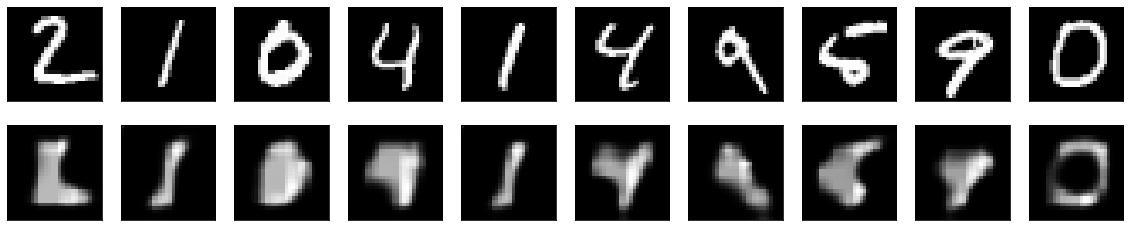

Starting epoch 1
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 25s 425us/step - loss: 0.1839 - val_loss: 0.1745


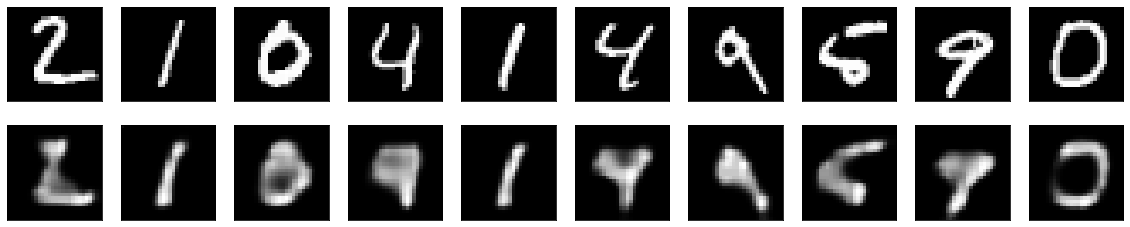

Starting epoch 2
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 25s 424us/step - loss: 0.1670 - val_loss: 0.1605


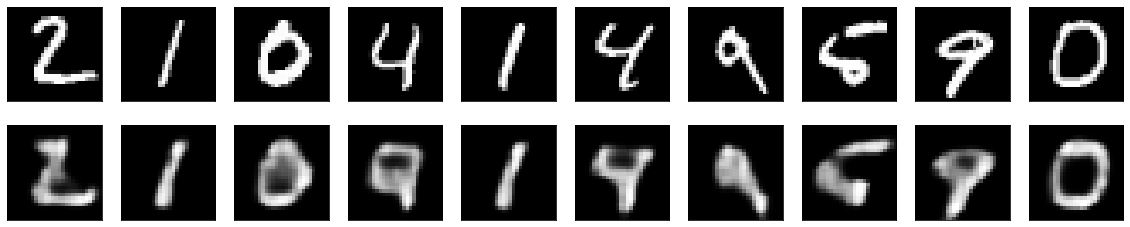

Starting epoch 3
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 25s 423us/step - loss: 0.1554 - val_loss: 0.1520


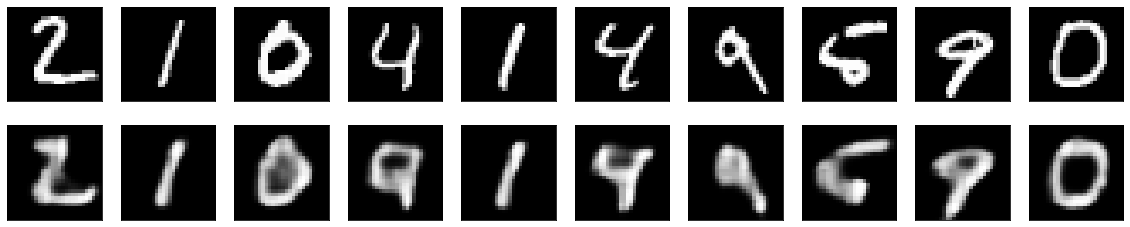

Starting epoch 4
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
17408/60000 [=======>......................] - ETA: 17s - loss: 0.1498

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    print('Starting epoch {}'.format(epoch))
    autoencoder.fit(x_train, x_train,
                    epochs=1,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])
    plot_results(autoencoder, x_test)

___

# Experiment, with WLB.

#### Redefine TensorFlow backend binary_crossentropy to apply random exponential weights.

In [ ]:
import pdb

In [ ]:
# Pointer to hint on custom loss function in Keras.
# https://stackoverflow.com/questions/43818584/custom-loss-function-in-keras
# https://github.com/keras-team/keras/blob/5a7a789ee9766b6a594bd4be8b9edb34e71d6500/keras/losses.py#L76

def wlb_binary_crossentropy(y_true, y_pred):
    # Weight loss with random exponential weights over true points.
    # Workaround to get exponential random variables of batch size (without TFProbability).
    
    #exp_weights_too_big = -1 * tf.log(tf.random.uniform(shape=tf.shape(y_true)))
    #exp_weights = tf.reshape(exp_weights_too_big[:, 0, 0, 0], [-1, 1])
    exp_weights = -1 * tf.log(tf.random.uniform(shape=(tf.shape(y_true)[0], 1)))
    exp_weights = exp_weights[tf.newaxis, tf.newaxis, :, 0]
    exp_weights = tf.tile(exp_weights, [y_pred.shape[1], y_pred.shape[1], 1])
    exp_weights = tf.transpose(exp_weights, [2, 0, 1])

    return exp_weights * tf.reduce_mean(binary_crossentropy(y_true, y_pred), axis=-1)
    #return K.mean(binary_crossentropy(y_true, y_pred), axis=-1)
    return K.mean(exp_weights * binary_crossentropy(y_true, y_pred), axis=-1)


def binary_crossentropy(target, output):
    """Binary crossentropy between an output tensor and a target tensor.
    
    Arguments
      target: A tensor with the same shape as `output`.
      output: A tensor.

    Returns
      A tensor.
    """
    # Note: tf.nn.sigmoid_cross_entropy_with_logits
    # expects logits, Keras expects probabilities.
    # transform back to logits
    _epsilon = tf.convert_to_tensor(1e-07, output.dtype.base_dtype)
    output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
    output = tf.log(output / (1 - output))

    return tf.nn.sigmoid_cross_entropy_with_logits(labels=target,
                                                   logits=output)

In [ ]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder_wlb = Model(input_img, decoded)

# This line runs the new loss.
autoencoder_wlb.compile(optimizer='adadelta',
                        loss=wlb_binary_crossentropy)

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    print('Starting epoch {}'.format(epoch))
    autoencoder_wlb.fit(x_train, x_train,
                        epochs=1,
                        batch_size=256,
                        shuffle=True,
                        validation_data=(x_test, x_test),
                        #callbacks=[TensorBoard(log_dir='/tmp/autoencoder')]
                       )
    plot_results(autoencoder_wlb, x_test)

In [ ]:
import tensorflow as tf
sess = tf.InteractiveSession()
r = tf.constant(np.random.normal(size=(3, 3)))
print(r.eval())
w = np.array([[1], [2], [3]])
w = [1, 2, 3]
print(w)
print(r.eval() * w)
sess.close()